# Autoencoder implementation from scratch

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/21zasker/Autoencoder/blob/master/Autoencoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/21zasker/Autoencoder/blob/master/Autoencoder.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This notebook showcases the implementation of an autoencoder neural network using the backpropagation algorithm with momentum, operating on 16x16 images to demonstrate its performance.

**What are autoencoders?**

Autoencoders are a type of neural networks in which the output tries to resemble the input as much as possible. They are trained in an unsupervised manner and have an architecture of three components:

* Encoder
* Latent space
* Decoder

The **encoder** is responsible for compressing information into a smaller representation (**latent space**), and the **decoder** aims to reconstruct the original input from this latent space.

**Backpropagation and momentum**

In autoencoder training, we use backpropagation to minimize the gap between the reconstructed output and the original input. It works by adjusting weights through gradient descent and uses momentum to make this process smoother.It adds a fraction of the previous weight update to the current update, promoting a more stable convergence.

## Setup

### Import libraries

In [9]:
from urllib.request import urlopen
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

### Resources

The `Resources` folder from the repository contains the images used in this notebook (All of them are 16x16).

In [10]:
# GitHub raw content URL for the images
github_image_1 = 'https://raw.githubusercontent.com/21zasker/Autoencoder/main/Resources/chicken.png'
github_image_2 = 'https://raw.githubusercontent.com/21zasker/Autoencoder/main/Resources/pill.png'
github_image_3 = 'https://raw.githubusercontent.com/21zasker/Autoencoder/main/Resources/gato.png'

# Open the images
original_image1 = Image.open(urlopen(github_image_1)).convert("RGB")
original_image2 = Image.open(urlopen(github_image_2)).convert("RGB")
original_image3 = Image.open(urlopen(github_image_3)).convert("RGB")

original_images = [original_image1, original_image2, original_image3]

# Get the width and height of the image
width, height = original_image1.size

# Convert the images to arrays and normalize pixel values to the range [0, 1]
original_image_arrays = np.array([np.array(img) / 255.0 for img in original_images])

## Build, train and test the model

The model's architecture adopts a tensor structure, organizing the neural network into layers with dimensions specified by `input_neurons`, `hidden_neurons`, and `output_neurons`. The tensor, represented by `self.mlp`, encapsulates the values across these layers.

### Build the model

In [11]:
class MultilayerPerceptron:
  def __init__(self, input_neurons_x, input_neurons_y, input_neurons_z,
               hidden_neurons, dimensions, learning_rate, momentum_rate):

    # Input neuorns made to fit an image with its 3 channels (RGB)
    self.input_neurons = input_neurons_x * input_neurons_y * input_neurons_z
    # Hidden neurons store the latent space after encoding
    self.hidden_neurons = hidden_neurons * dimensions
    # Output neurons store the decoded image
    self.output_neurons = input_neurons_x * input_neurons_y * input_neurons_z
    self.learning_rate = learning_rate
    self.momentum_rate = momentum_rate

    # AUTOENCODER STRUCTURE
    self.mlp = [np.zeros(self.input_neurons)] + [np.zeros(self.hidden_neurons)
    for _ in range(self.hidden_neurons)] + [np.zeros(self.output_neurons)]

    # Randomly assigned weights
    np.random.seed(0)
    self.weights = [np.random.normal(-0.1, 0.1,
     (self.mlp[i + 1].size,
      self.mlp[i].size)) for i in range(len(self.mlp) - 1)]

    # The errors of each layer will be stored here
    self.errors = [np.zeros((weights.shape[0],)) for weights in self.weights]

    # The weights before being updated will be stored here
    self.previous_weights = [np.zeros(weights.shape) for weights in self.weights]

  # FORWARD PROPAGATION:
  # Does the encoder and decoder function by compressing input data (input layer)
  # to latent space (hidden layer), then reconstructs the data (output layer)
  def forward_propagation(self, input_data):
    self.mlp[0] = input_data.flatten()

    for i in range(len(self.weights)):
      for j in range(self.weights[i].shape[0]):
        weighted_sum = np.dot(self.mlp[i], self.weights[i][j])
        self.mlp[i + 1][j] = self.sigmoid_function(False, weighted_sum)

    return self.mlp[-1]

  # BACKPROPAGATION:
  # Compares the output image to the original image to get the errors from
  # each layer and update the weights
  def back_propagation(self, output_data):
    output_data = output_data.flatten()
    for i in reversed(range(1, len(self.mlp))):
      for j in range(len(self.mlp[i])):
        if i == len(self.mlp) - 1: # (Output layer)
          self.errors[i - 1][j] = (self.mlp[i][j] - output_data[j])**3
        else: #(Rest of the layers)
          self.errors[i - 1][j] = np.dot(self.errors[i], self.weights[i][:, j])

        # Recalculo de 'z'
        z = np.dot(self.mlp[i - 1], self.weights[i - 1][j])

        for k in range(len(self.mlp[i - 1])):
          # Updated weights without momentum
          weights_updates = (self.learning_rate * self.errors[i - 1][j] * self.mlp[i - 1][k] * self.sigmoid_function(True, z))

          # Adds momentum to the updated weights
          weights_updates += self.momentum_rate * self.previous_weights[i - 1][j][k]

          # Saves the updated weights and the new previous weights
          self.weights[i - 1][j][k] -= weights_updates
          self.previous_weights[i - 1][j][k] = weights_updates

  # Activation function and its derivative
  def sigmoid_function(self, derivative, z):
    sig = 1 / (1 + np.exp(-z))
    return sig * (1 - sig) if derivative else sig

  # TRAINING FUNCTION
  def train(self, epochs, original_image_array):
    for epoch in range(epochs):
      stop_training = True

      # Autoencoder
      output = self.forward_propagation(original_image_array)
      self.back_propagation(original_image_array)

      # Early stop
      if np.mean((output - original_image_array.flatten()) ** 2) > 0.001:
        stop_training = False

      if stop_training:
        print(f"Training finished in epoch {epoch + 1}")
        break

  # TESTING FUNCTION
  def test(self, original_image_array):
    reconstructed_flat = self.forward_propagation(original_image_array)
    reconstructed_image = (reconstructed_flat * 255).astype(int).reshape((height, width, 3))
    return reconstructed_image

### Train and test the model

Configure the autoencoder with parameters corresponding to the image width and height for the input neurons (`x`, `y`, and `z` representing the 3 RGB channels, so it has 3 `dimensions`). Additionally, set the number of hidden neurons and the learning and momentum rate.

In [12]:
autoencoder = MultilayerPerceptron(input_neurons_x=width, input_neurons_y=height,
                                   input_neurons_z=3, hidden_neurons=1, dimensions=3,
                                   learning_rate=1, momentum_rate=0.954)

Then, train the autoencoder over several epochs and evaluate its performance by comparing the post-training decoded image with the original.

In [13]:
# Training
autoencoder.train(epochs=800, original_image_array=original_image_arrays[0])

# Create the reconstructed image
reconstructed_image = autoencoder.test(original_image_array=original_image_arrays[0])

Training finished in epoch 365


In [14]:
# Saves the reconstructed image to plot it with rest at the end
reconstructed_images = []
reconstructed_images.append(reconstructed_image)

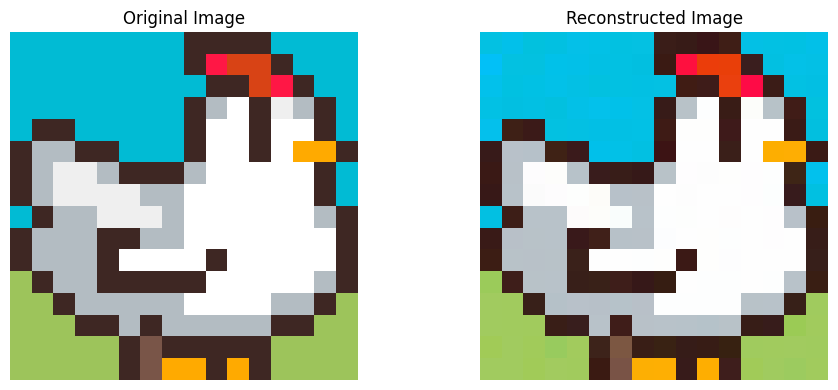

In [15]:
# Display the original image and the reconstructed image.
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_images[0])
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.axis('off')
plt.title('Reconstructed Image')

plt.tight_layout()
plt.show()

## Results

Create another two autoencoders for the rest of the images and plot the complete results

In [16]:
# Autoencoders for each image
autoencoders = [
    MultilayerPerceptron(input_neurons_x=width, input_neurons_y=height, input_neurons_z=3,
                         hidden_neurons=1, dimensions=3, learning_rate=1, momentum_rate=0.954),
    MultilayerPerceptron(input_neurons_x=width, input_neurons_y=height, input_neurons_z=3,
                         hidden_neurons=1, dimensions=3, learning_rate=1, momentum_rate=0.954)
]

In [17]:
# Training the new autoencoder
autoencoders[0].train(epochs=800, original_image_array=original_image_arrays[1])
autoencoders[1].train(epochs=800, original_image_array=original_image_arrays[2])

Training finished in epoch 42


In [18]:
# Add the reconstructed images to the list
reconstructed_images.append(autoencoders[0].test(original_image_array=original_image_arrays[1]))
reconstructed_images.append(autoencoders[1].test(original_image_array=original_image_arrays[2]))

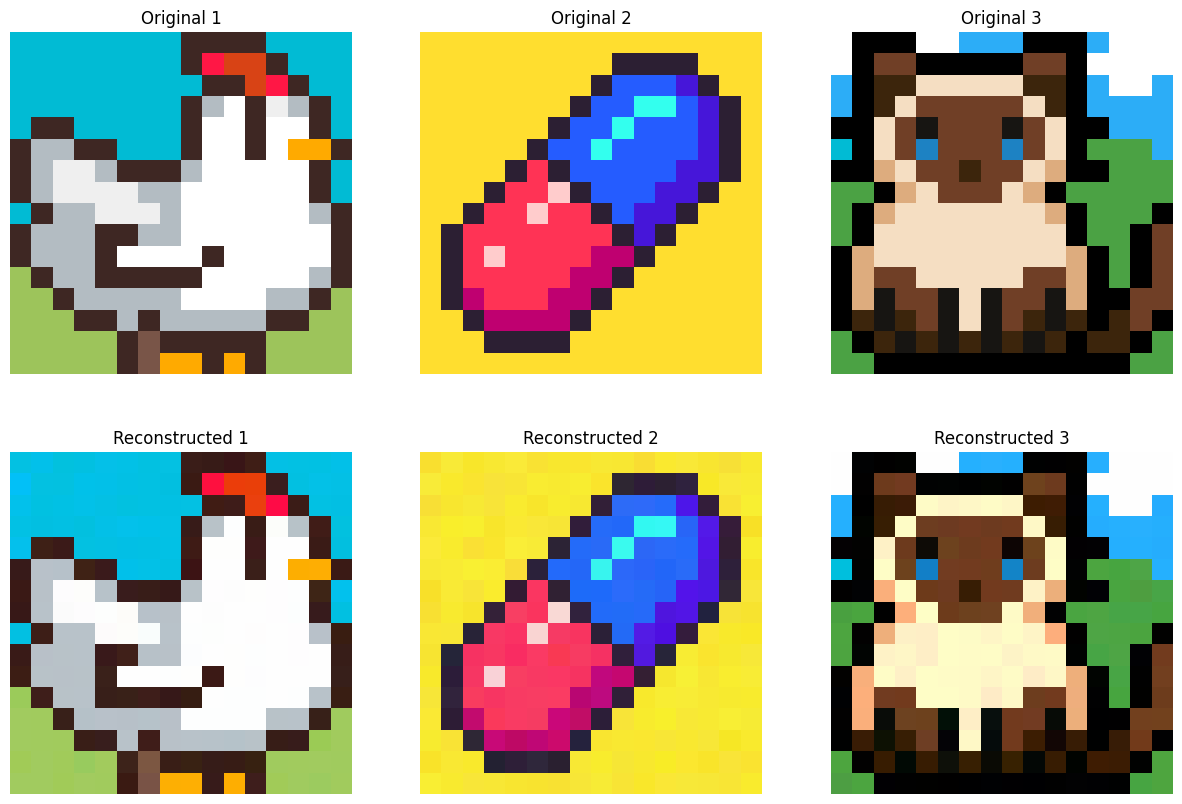

In [19]:
# Plot original images in the first row
plt.figure(figsize=(15, 10))

for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(original_images[i])
    plt.title(f'Original {i + 1}')
    plt.axis('off')

# Plot recovered images in the second row
for i in range(3):
    plt.subplot(2, 3, i + 4)
    plt.imshow(reconstructed_images[i])
    plt.title(f'Reconstructed {i + 1}')
    plt.axis('off')

plt.show()